<a href="https://colab.research.google.com/github/filipbyberg/Age-Gender-Mood-classification-CNN/blob/main/Train_age_Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Plan**

**Our age prediction CNN model shall be defined and trained by:**

1. Importing training and test datasets from Google Drive Input Sub-folder
2. Training dataset is already augmented and has 234,000 images
3. Greyscaling images instead of using RGB color images
4. Defining our intuitively distributed classes of age-ranges
5. Using 20 epochs on our optimized CNN Architecture, comprising of:
- an input Conv2D layer (with 32 filters) paired with an AveragePooling2D layer,
- 3 pairs of Conv2D (with 64, 128 & 256 filters) and AveragePooling2D layers,
- a GlobalAveragePooling2D layer,
- 1 Dense layer with 132 nodes, and
- an output Dense layer with 7 nodes.

# Mount Google Drive & Imports

In [ ]:
#@title Mount Google Drive {display-mode: "form"}

from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

All essential libraries and functions to be used in the project have been imported.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
import os
from zipfile import ZipFile
import time
from datetime import datetime
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Conv2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.python.keras import utils
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint

# Setting random seeds to reduce the amount of randomness in the neural net weights and results
# The results may still not be exactly reproducible

np.random.seed(42)
tf.random.set_seed(42)

## Check for GPU


In [ ]:
#@title Check for GPU

# Testing to ensure GPU is being utilized

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Data Preparation

UTK Faces and Facial Age datasets were combined to build the Age Detection model of the project. With these two datasets combined, there are around 34000 labelled facial images from age 1 to 116 to work with. Although we have about 34000 images, more than that is needed to train a neural network with good accuracy. For this reason, 70% of all data reserved for training has been expanded 10 times with the data augmentation technique.

## Import Dataset

Importing augmented training set and test set along with their labels.

Unzipping test set.

In [ ]:
combined_faces_zip_path = "/content/drive/MyDrive/Machine_learning_Project/Input_Output_Age/Input/combined_faces.zip"

with ZipFile(combined_faces_zip_path, 'r') as myzip:
    myzip.extractall()
    print('Done unzipping combined_faces.zip')

Done unzipping combined_faces.zip


Unzipping augmented training set.

In [ ]:
combined_faces_zip_path = "/content/drive/MyDrive/Machine_learning_Project/Input_Output_Age/Input/combined_faces_train_augmented.zip"

with ZipFile(combined_faces_zip_path, 'r') as myzip:
    myzip.extractall()
    print('Done unzipping combined_faces_train_augmented.zip')

Done unzipping combined_faces_train_augmented.zip


Reading labels from zip files.

Importing the augmented training dataset and testing dataset to create tensors of images using the filename paths.

In [ ]:
train_aug_set = pd.read_csv("/content/drive/MyDrive/Machine_learning_Project/Input_Output_Age/Input/images_filenames_labels_train_augmented.csv")
test_set = pd.read_csv("/content/drive/MyDrive/Machine_learning_Project/Input_Output_Age/Input/images_filenames_labels_test.csv")

## Know your Dataset

In [ ]:
train_aug_set.head()

,filename,age
0,/content/content/combined_faces_train_augmente...,43
1,/content/content/combined_faces_train_augmente...,71
2,/content/content/combined_faces_train_augmente...,6
3,/content/content/combined_faces_train_augmente...,18
4,/content/content/combined_faces_train_augmente...,25


In [ ]:
train_aug_set.shape

(234400, 2)

In [ ]:
test_set.head()

,filename,age
0,/content/content/combined_faces/8_163.jpg,8
1,/content/content/combined_faces/38_66.jpg,38
2,/content/content/combined_faces/40_177.jpg,40
3,/content/content/combined_faces/36_267.jpg,36
4,/content/content/combined_faces/8_349.jpg,8


In [ ]:
test_set.shape

(10046, 2)

## Define Age Classes

Defining age classes.

Defining a function to return the class labels corresponding to the re-distributed 7 age-ranges.


In [ ]:
def class_labels_reassign(age):

    if 1 <= age <= 2:
        return 0
    elif 3 <= age <= 9:
        return 1
    elif 10 <= age <= 20:
        return 2
    elif 21 <= age <= 27:
        return 3
    elif 28 <= age <= 45:
        return 4
    elif 46 <= age <= 65:
        return 5
    else:
        return 6

A new column has been created in the training and test set label data frames for the newly defined age classes.

In [ ]:
train_aug_set['Age Group'] = train_aug_set['age'].map(class_labels_reassign)
test_set['Age Group'] = test_set['age'].map(class_labels_reassign)

In [ ]:
train_aug_set.head()

,filename,age,Age Group
0,/content/content/combined_faces_train_augmente...,43,4
1,/content/content/combined_faces_train_augmente...,71,6
2,/content/content/combined_faces_train_augmente...,6,1
3,/content/content/combined_faces_train_augmente...,18,2
4,/content/content/combined_faces_train_augmente...,25,3


In [ ]:
test_set.head()

,filename,age,Age Group
0,/content/content/combined_faces/8_163.jpg,8,1
1,/content/content/combined_faces/38_66.jpg,38,4
2,/content/content/combined_faces/40_177.jpg,40,4
3,/content/content/combined_faces/36_267.jpg,36,4
4,/content/content/combined_faces/8_349.jpg,8,1


## Organize Dataset


Storing filename and target for both train and test sets into list.

In [ ]:
train_aug_filenames_list = list(train_aug_set['filename'])
train_aug_targets_list = list(train_aug_set['Age Group'])

test_filenames_list = list(test_set['filename'])
test_targets_list = list(test_set['Age Group'])

Tensorflow constants have been created for the lists created above.

In [ ]:
train_aug_filenames_tensor = tf.constant(train_aug_filenames_list)
train_aug_targets_tensor = tf.constant(train_aug_targets_list)

test_filenames_tensor = tf.constant(test_filenames_list)
test_targets_tensor = tf.constant(test_targets_list)

## Image Greyscale Function

In order to reduce the computational power we may need to build this model, all training set images should be converted to grayscale.

Defining a function to read the image, decode the image from given tensor and one-hot encode the image label class.

Changing the channels para in tf.io.decode_jpeg from 3 to 1 changes the output images from RGB coloured to grayscale.

In [ ]:
num_classes = 7

def _parse_function(filename, label):

    image_read = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_read, channels=1)

    label = tf.one_hot(label, num_classes)

    return image_decoded, label

Passing all training and test images to the above defined function for converting them to grayscale.

Getting the dataset ready for the neural network.

Using the tensor vectors defined above, accessing the images in the dataset and passing them through the function defined above.

In [ ]:
train_aug_dataset = tf.data.Dataset.from_tensor_slices((train_aug_filenames_tensor, train_aug_targets_tensor))
train_aug_dataset = train_aug_dataset.map(_parse_function)

train_aug_dataset = train_aug_dataset.batch(64)

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_targets_tensor))
test_dataset = test_dataset.map(_parse_function)

test_dataset = test_dataset.batch(64)

# CNN Architecture

Defining CNN Architecture

(#1), we have an input 2D Convolutional layer (with 32 filters) paired with an 2D AveragePooling layer.

(#2), we have 3 pairs of 2D Convolutional layer (with 64, 128 and 256 filters) paired again with 2D AveragePooling layers.

(#3), we have a 2D GlobalAveragePooling layer.

(#4), One dense layer with 132 nodes.

(#5), Output dense layer with 7 nodes.

In [ ]:
# Defining the architecture of the sequential neural network.

final_cnn = Sequential()
#1
final_cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(200, 200, 1)))    # 3rd dim = 1 for grayscale images.
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

#2
final_cnn.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

#3
final_cnn.add(GlobalAveragePooling2D())

#4
final_cnn.add(Dense(132, activation='relu'))

#5
final_cnn.add(Dense(7, activation='softmax'))

final_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 32)      320       
_________________________________________________________________
average_pooling2d (AveragePo (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
average_pooling2d_1 (Average (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 128)       73856     
_________________________________________________________________
average_pooling2d_2 (Average (None, 23, 23, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 256)       2

Compiling the above created CNN architecture.

In [ ]:
final_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Provisioning for storing CNN logs.

Creating a TensorBoard callback object and saving it at the desired location.

In [ ]:
tensorboard = TensorBoard(log_dir=f"/content/drive/MyDrive/Machine_learning_Project/Input_Output_Age/Output/cnn_log")

We shall also use **ModelCheckpoint** as a callback while training the final CNN model so as to be able to save the model as it continues training and improving in performance.

Creating a ModelCheckpoint callback object to save the model according to the value of val_accuracy.

In [ ]:
checkpoint = ModelCheckpoint(filepath=f"/content/drive/MyDrive/Machine_learning_Project/Input_Output_Age/Output/cnn_log/age_model_checkpoint.h5",
                             monitor='val_accuracy',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1
                            )

# Model Fitting

Fitting the above created CNN model.

In [ ]:
final_cnn_history = final_cnn.fit(train_aug_dataset,
                                  batch_size=64,
                                  validation_data=test_dataset,
                                  epochs=20,
                                  callbacks=[tensorboard, checkpoint],
                                  shuffle=False # to reduce randomness and increase reproducibility
                                 )

Epoch 1/20
3663/3663 [==============================] - 318s 83ms/step - loss: 1.3992 - accuracy: 0.4325 - val_loss: 1.1260 - val_accuracy: 0.5252

Epoch 00001: val_accuracy improved from -inf to 0.52518, saving model to /content/drive/MyDrive/Machine_learning_Project/Input_Output_Age/Output/cnn_log/age_model_checkpoint.h5
Epoch 2/20
3663/3663 [==============================] - 289s 79ms/step - loss: 1.0303 - accuracy: 0.5658 - val_loss: 1.0198 - val_accuracy: 0.5664

Epoch 00002: val_accuracy improved from 0.52518 to 0.56639, saving model to /content/drive/MyDrive/Machine_learning_Project/Input_Output_Age/Output/cnn_log/age_model_checkpoint.h5
Epoch 3/20
3663/3663 [==============================] - 288s 79ms/step - loss: 0.9089 - accuracy: 0.6134 - val_loss: 0.9010 - val_accuracy: 0.6138

Epoch 00003: val_accuracy improved from 0.56639 to 0.61378, saving model to /content/drive/MyDrive/Machine_learning_Project/Input_Output_Age/Output/cnn_log/age_model_checkpoint.h5
Epoch 4/20
3663/366

# Checking Model Performance

In [ ]:
train_loss = final_cnn_history.history['loss']
test_loss = final_cnn_history.history['val_loss']
train_accuracy = final_cnn_history.history['accuracy']
test_accuracy = final_cnn_history.history['val_accuracy']

Plotting a line chart to visualize the loss and accuracy values by epochs.

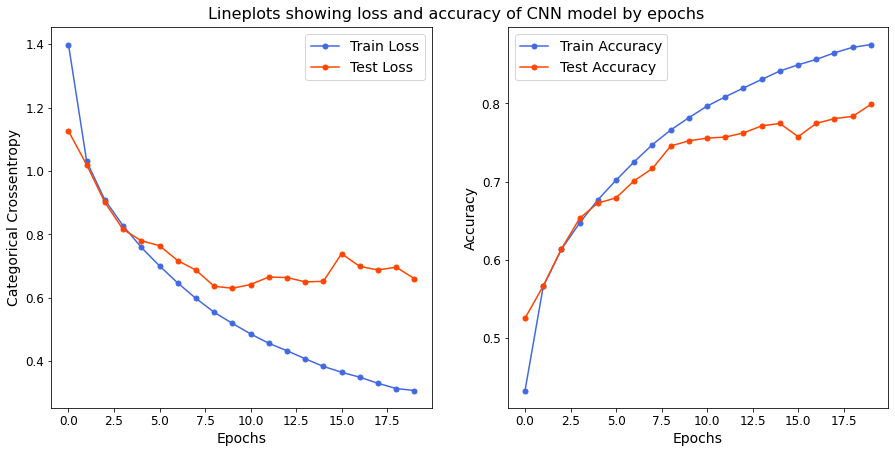

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16)

# Exporting plot image in PNG format.
plt.savefig('/content/drive/My Drive/Machine_learning_Project/Input_Output_Age/Output/cnn_log/final_cnn_loss_accuracy.png', bbox_inches='tight');

Evaluating the model on test dataset.

In [ ]:
final_cnn_score = final_cnn.evaluate(test_dataset, verbose=1)

157/157 [==============================] - 5s 30ms/step - loss: 0.6608 - accuracy: 0.7988


Printing the relevant score summary.

In [ ]:
final_cnn_labels = final_cnn.metrics_names
print(f'CNN model {final_cnn_labels[0]} \t\t= {round(final_cnn_score[0], 3)}')
print(f'CNN model {final_cnn_labels[1]} \t= {round(final_cnn_score[1], 3)}')

CNN model loss 		= 0.661
CNN model accuracy 	= 0.799


Saving the model as a h5 file for possible use later.

In [ ]:
final_cnn.save(f"/content/drive/My Drive/Machine_learning_Project/Input_Output_Age/Output/2age_model_acc_{round(final_cnn_score[1], 3)}.h5", save_format='h5')

# Plotting Confusion Matrix

Generating predictions from the model.

In [ ]:
final_cnn_pred = final_cnn.predict(test_dataset)
final_cnn_pred = final_cnn_pred.argmax(axis=-1)

Generating a confusion matrix based on above predictions.

In [ ]:
conf_mat = confusion_matrix(test_targets_list, final_cnn_pred)
conf_mat

array([[ 922,   29,    0,    1,    0,    2,    4],
       [  43,  732,   43,   16,    6,    5,    0],
       [   0,   51,  750,   84,   46,    9,    1],
       [   0,    5,   64, 1337,  557,   42,    2],
       [   2,    4,   24,  283, 2130,  357,    7],
       [   2,    1,    2,   13,  123, 1441,   97],
       [   0,    1,    0,    1,    4,   90,  713]])

Defining a function to plot the confusion matrix in a grid for easier visualization.

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', export_as='confusion_matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True labels', fontsize=14)
    plt.xlabel('Predicted labels', fontsize=14)

    # Exporting plot image in PNG format.
    plt.savefig(f'/content/drive/My Drive/Machine_learning_Project/Input_Output_Age/Output/cnn_log/{export_as}.png', bbox_inches='tight');

Plotting the confusion matrix using the function defined above.

Normalized confusion matrix


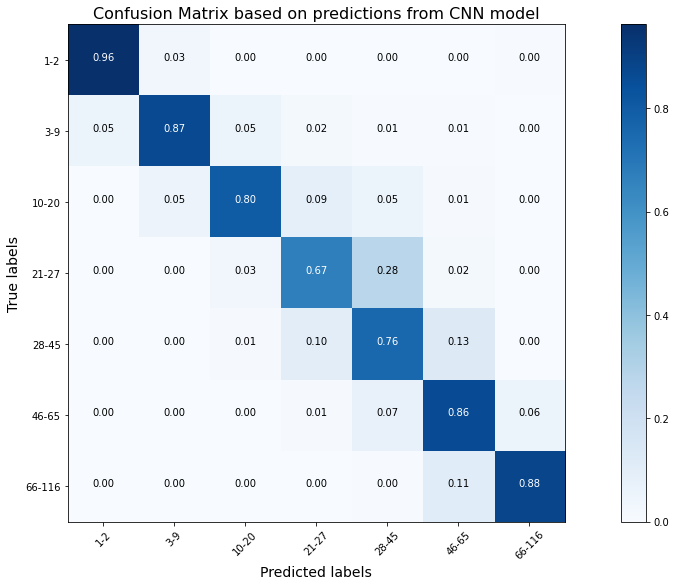

In [ ]:
cm_plot_labels = ['1-2', '3-9', '10-20', '21-27', '28-45', '46-65', '66-116']

plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from CNN model",
                      export_as="final_cnn_conf_mat_norm"
                     )

plt.show()